# Rice Dataset

## Présentation du Dataset

### 1. Description du Dataset
Le dataset utilisé provient du site [Murat Koklu](https://www.muratkoklu.com/datasets/) et contient des informations morphologiques sur deux variétés de riz : **Cammeo** et **Osmancik**. 

- **Nombre total d'instances :** 3810 grains de riz
- **Nombre total d'attributs :** 7 caractéristiques morphologiques + 1 classe cible
- **Classes cibles :** Cammeo et Osmancik (classification binaire)

### 2. Attributs du Dataset
1. **Area** : Nombre de pixels à l'intérieur des contours du grain de riz.
2. **Perimeter** : Circonférence du grain de riz en calculant la distance entre les pixels du contour.
3. **Major Axis Length** : La plus grande ligne qui peut être tracée sur le grain de riz (longueur de l'axe principal).
4. **Minor Axis Length** : La plus petite ligne qui peut être tracée sur le grain de riz (longueur de l'axe secondaire).
5. **Eccentricity** : Mesure de la circularité de l'ellipse ayant les mêmes moments que le grain de riz.
6. **Convex Area** : Nombre de pixels de la plus petite enveloppe convexe du grain de riz.
7. **Extent** : Rapport entre la surface du grain de riz et la boîte englobante.
8. **Class** : Catégorie du riz (Cammeo ou Osmancik).


## Méthodologie de Sélection de Variables

Nous allons comparer trois approches de sélection de variables afin d'améliorer la performance de la classification :

### 1. **Recherche exhaustive** (Exhaustive Search)
Nous testons toutes les combinaisons possibles d'attributs pour identifier la meilleure sélection en fonction de plusieurs métriques (accuracy, F1-score, précision). Cette approche est coûteuse en temps de calcul mais garantit d'identifier l'ensemble optimal de variables.

### 2. **Sélection séquentielle avant (SFS Forward)**
Nous commençons avec un seul attribut et ajoutons progressivement ceux qui améliorent le plus la performance du modèle.

### 3. **Sélection séquentielle arrière (SFS Backward)**
Nous commençons avec tous les attributs et supprimons progressivement ceux qui ont le moins d'impact sur la performance.

# KNN (accuracy, F1-score, précision)
## Sélection exhaustive des caractéristiques avec KNN 

In [2]:
import pandas as pd
import time 
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score
import numpy as np
import random

# Déclaration d'une variable globale pour stocker les résultats
global_results_df_knn = None

def evaluate_feature_combinations(data, classifier, cv=3, seed=3):
    global global_results_df_knn

    start_time = time.time()
    
    # Encode categorical attributes
    label_encoders = {}
    for column in data.columns:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

    X = data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière
    y = data.iloc[:, -1]   # Seulement la dernière colonne

    # Vérification de l'équilibre des classes
    class_counts = y.value_counts()
    min_class_size = class_counts.min()
    
    if min_class_size < cv:
        print(f"Reducing cv from {cv} to {min_class_size} due to class imbalance.")
        cv = min_class_size

    features = X.columns.tolist()
    results = []
    subsets = [()] + [subset for r in range(1, len(features) + 1) for subset in combinations(features, r)]

    # Définir les métriques à tester
    scoring_metrics = {
        "accuracy": make_scorer(accuracy_score),
        "f1_score": make_scorer(f1_score, average='weighted'),
        "precision": make_scorer(precision_score, average='weighted')
    }

    for subset in subsets:
        scores_dict = {metric: [] for metric in scoring_metrics.keys()}

        for s in range(seed):
            random.seed(s)

            if len(subset) == 0:
                X_selected = pd.DataFrame(index=X.index)
            else:
                X_selected = X[list(subset)]

            try:
                for metric, scorer in scoring_metrics.items():
                    cv_scores = cross_val_score(classifier, X_selected, y, cv=cv, scoring=scorer)
                    scores_dict[metric].extend(cv_scores)
            except ValueError:
                for metric in scoring_metrics.keys():
                    scores_dict[metric] = [0] * cv

        # Stocker les moyennes des scores pour chaque métrique
        row = {f'feature{features.index(feature) + 1}': 1 if feature in subset else 0 for feature in features}
        for metric in scoring_metrics.keys():
            row[f'mean_{metric}'] = np.mean(scores_dict[metric])

        results.append(row)

    results_df = pd.DataFrame(results)

    # Trouver les meilleurs scores pour chaque métrique
    best_scores = {metric: results_df[f'mean_{metric}'].max() for metric in scoring_metrics.keys()}

    # Ajouter les écarts par rapport aux meilleurs scores
    for metric in scoring_metrics.keys():
        results_df[f'gap1_{metric}'] = best_scores[metric] - results_df[f'mean_{metric}']
        results_df[f'gap2_{metric}'] = results_df[f'gap1_{metric}'] / best_scores[metric]

    ordered_columns = [col for col in results_df.columns if col.startswith('feature')] 
    ordered_columns += [f'mean_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap1_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap2_{metric}' for metric in scoring_metrics.keys()]

    results_df = results_df[ordered_columns]

    # Sauvegarde dans un fichier Excel
    results_df.to_excel('C:/Users/PC/Documents/rice+cammeo+and+osmancik/results_KNN_rice.xlsx', index=False)
    global_results_df_knn = results_df

    print(f"Best mean accuracy: {best_scores['accuracy']:.4f}")
    print(f"Best mean f1-score: {best_scores['f1_score']:.4f}")
    print(f"Best mean precision: {best_scores['precision']:.4f}")


     # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")
    return results_df

# Chargement des données
data = pd.read_csv('C:/Users/PC/Documents/rice+cammeo+and+osmancik/Rice.data', header=None)

# Initialisation du modèle KNN
classifier = KNeighborsClassifier(n_neighbors=3)

# Exécution de la fonction avec plusieurs métriques
df_results = evaluate_feature_combinations(data, classifier, cv=3, seed=3)

# Affichage des résultats globaux
print("\n--- Résultats globaux ---")
print(global_results_df_knn.head())

Best mean accuracy: 0.9178
Best mean f1-score: 0.9178
Best mean precision: 0.9179

--- Résultats globaux ---
   feature1  feature2  feature3  feature4  feature5  feature6  feature7  \
0         0         0         0         0         0         0         0   
1         1         0         0         0         0         0         0   
2         0         1         0         0         0         0         0   
3         0         0         1         0         0         0         0   
4         0         0         0         1         0         0         0   

   mean_accuracy  mean_f1_score  mean_precision  gap1_accuracy  gap1_f1_score  \
0       0.000000       0.000000        0.000000       0.917848       0.917767   
1       0.855381       0.854952        0.855113       0.062467       0.062815   
2       0.894488       0.894230        0.894428       0.023360       0.023536   
3       0.906037       0.906032        0.906394       0.011811       0.011735   
4       0.615223       0.612197    

## SFS (backward + forward), accuracy_score, KNN

+----------------------+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   |
+======================+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   | ✔   | ✔   |     |     |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          |     | ✔   | ✔   |     |     |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     |     |     | ✔   | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9178
Score SFS Forward : 0.9169
Score SFS Backward : 0.9169
Gap2 SFS Forward : 0.0063 | Gap2 SFS Backward : 0.0057


C:\Users\PC\AppData\Local\Temp\ipykernel_31604\2725111963.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


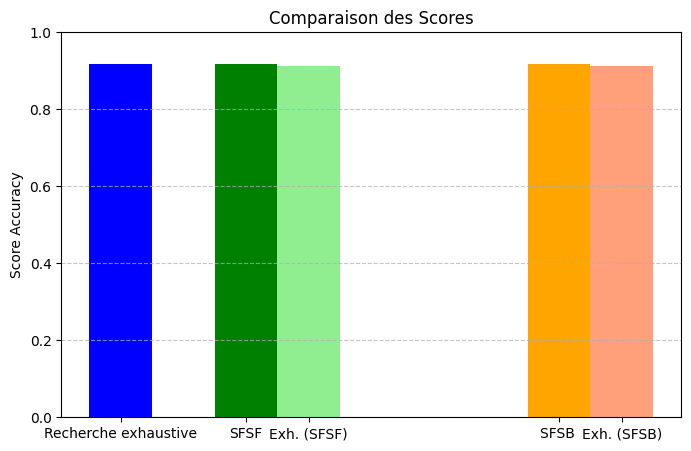

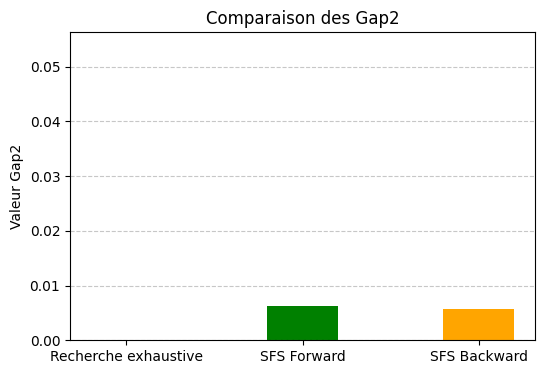

Temps d'exécution : 4.76 secondes


In [25]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_knn  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['gap2_accuracy'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_knn['mean_accuracy'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['mean_accuracy'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_knn.loc[global_results_df_knn['mean_accuracy'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score Accuracy', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/PC/Documents/rice+cammeo+and+osmancik/Rice.data'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=KNeighborsClassifier(n_neighbors=5),
    score_func=accuracy_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), f1_score, KNN

+----------------------+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   |
+======================+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   | ✔   | ✔   |     |     |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          |     | ✔   | ✔   |     |     |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     |     |     | ✔   | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9178
Score SFS Forward : 0.9261
Score SFS Backward : 0.9264
Gap2 SFS Forward : 0.0063 | Gap2 SFS Backward : 0.0057


C:\Users\PC\AppData\Local\Temp\ipykernel_31604\458690621.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


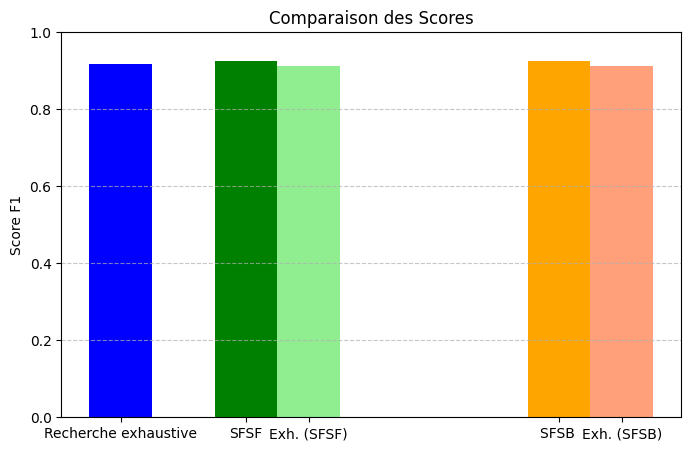

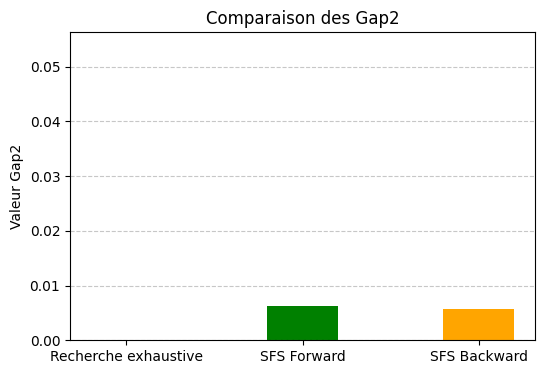

Temps d'exécution : 5.03 secondes


In [27]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_knn  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['gap2_f1_score'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_knn['mean_f1_score'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['mean_f1_score'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_knn.loc[global_results_df_knn['mean_f1_score'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score F1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/PC/Documents/rice+cammeo+and+osmancik/Rice.data'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=KNeighborsClassifier(n_neighbors=5),
    score_func=f1_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), precision_score, KNN

C:\Users\PC\AppData\Local\Temp\ipykernel_31604\524535226.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


+----------------------+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   |
+======================+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   | ✔   | ✔   |     |     |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          |     | ✔   | ✔   |     |     |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     |     |     | ✔   | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9179
Score SFS Forward : 0.9112
Score SFS Backward : 0.9074
Gap2 SFS Forward : 0.0063 | Gap2 SFS Backward : 0.0057


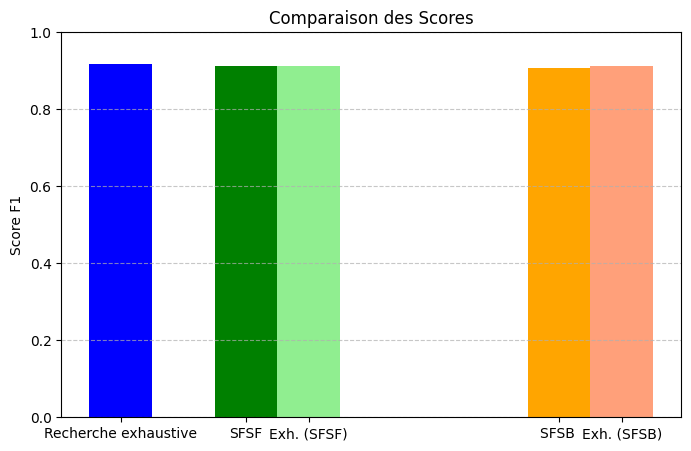

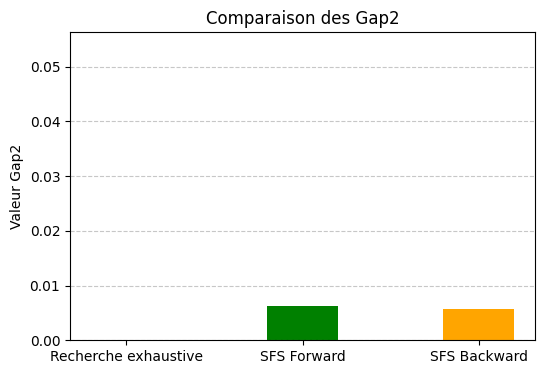

Temps d'exécution : 14.16 secondes


In [28]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_knn  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['gap2_precision'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_knn['mean_precision'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['mean_precision'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_knn.loc[global_results_df_knn['mean_precision'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score F1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/PC/Documents/rice+cammeo+and+osmancik/Rice.data'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=KNeighborsClassifier(n_neighbors=5),
    score_func=precision_score,
    cv_sfs=3,
    seed=1
)


# XGB (accuracy, F1-score, précision)
## Sélection exhaustive des caractéristiques avec XGB 

In [2]:
import pandas as pd
from itertools import combinations
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score
import numpy as np
import random
import time

# Déclaration d'une variable globale pour stocker les résultats
global_results_df_xgb = None

def evaluate_feature_combinations(data, classifier, cv=3, seed=3):
    global global_results_df_xgb

    start_time = time.time() #debut du chronometre
    
    # Encode categorical attributes
    label_encoders = {}
    for column in data.columns:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

    X = data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière
    y = data.iloc[:, -1]   # Seulement la dernière colonne

    # Vérification de l'équilibre des classes
    class_counts = y.value_counts()
    min_class_size = class_counts.min()
    
    if min_class_size < cv:
        print(f"Reducing cv from {cv} to {min_class_size} due to class imbalance.")
        cv = min_class_size

    features = X.columns.tolist()
    results = []
    subsets = [()] + [subset for r in range(1, len(features) + 1) for subset in combinations(features, r)]

    # Définir les métriques à tester
    scoring_metrics = {
        "accuracy": make_scorer(accuracy_score),
        "f1_score": make_scorer(f1_score, average='weighted'),
        "precision": make_scorer(precision_score, average='weighted')
    }

    for subset in subsets:
        scores_dict = {metric: [] for metric in scoring_metrics.keys()}

        for s in range(seed):
            random.seed(s)

            if len(subset) == 0:
                X_selected = pd.DataFrame(index=X.index)
            else:
                X_selected = X[list(subset)]

            try:
                for metric, scorer in scoring_metrics.items():
                    cv_scores = cross_val_score(classifier, X_selected, y, cv=cv, scoring=scorer)
                    scores_dict[metric].extend(cv_scores)
            except ValueError:
                for metric in scoring_metrics.keys():
                    scores_dict[metric] = [0] * cv

        # Stocker les moyennes des scores pour chaque métrique
        row = {f'feature{features.index(feature) + 1}': 1 if feature in subset else 0 for feature in features}
        for metric in scoring_metrics.keys():
            row[f'mean_{metric}'] = np.mean(scores_dict[metric])

        results.append(row)

    results_df = pd.DataFrame(results)

    # Trouver les meilleurs scores pour chaque métrique
    best_scores = {metric: results_df[f'mean_{metric}'].max() for metric in scoring_metrics.keys()}

    # Ajouter les écarts par rapport aux meilleurs scores
    for metric in scoring_metrics.keys():
        results_df[f'gap1_{metric}'] = best_scores[metric] - results_df[f'mean_{metric}']
        results_df[f'gap2_{metric}'] = results_df[f'gap1_{metric}'] / best_scores[metric]

    ordered_columns = [col for col in results_df.columns if col.startswith('feature')] 
    ordered_columns += [f'mean_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap1_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap2_{metric}' for metric in scoring_metrics.keys()]

    results_df = results_df[ordered_columns]

    # Sauvegarde dans un fichier Excel
    results_df.to_excel('C:/Users/PC/Documents/rice+cammeo+and+osmancik/results_XGB_rice.xlsx', index=False)
    global_results_df_xgb = results_df

    print(f"Best mean accuracy: {best_scores['accuracy']:.4f}")
    print(f"Best mean f1-score: {best_scores['f1_score']:.4f}")
    print(f"Best mean precision: {best_scores['precision']:.4f}")


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_df

# Chargement des données
data = pd.read_csv('C:/Users/PC/Documents/rice+cammeo+and+osmancik/Rice.data', header=None)

# Initialisation du modèle KNN
classifier = XGBClassifier(eval_metric='logloss')

# Exécution de la fonction avec plusieurs métriques
df_results = evaluate_feature_combinations(data, classifier, cv=3, seed=3)

# Affichage des résultats globaux
print("\n--- Résultats globaux ---")
print(global_results_df_xgb.head())

Best mean accuracy: 0.9236
Best mean f1-score: 0.9235
Best mean precision: 0.9240
Temps d'exécution : 467.25 secondes

--- Résultats globaux ---
   feature1  feature2  feature3  feature4  feature5  feature6  feature7  \
0         0         0         0         0         0         0         0   
1         1         0         0         0         0         0         0   
2         0         1         0         0         0         0         0   
3         0         0         1         0         0         0         0   
4         0         0         0         1         0         0         0   

   mean_accuracy  mean_f1_score  mean_precision  gap1_accuracy  gap1_f1_score  \
0       0.000000       0.000000        0.000000       0.923622       0.923452   
1       0.876115       0.875214        0.876878       0.047507       0.048238   
2       0.902625       0.902342        0.902679       0.020997       0.021110   
3       0.923622       0.923452        0.923967       0.000000       0.000000   

## SFS (backward + forward), accuracy_score, XGB

C:\Users\PC\AppData\Local\Temp\ipykernel_64384\1870436.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


+----------------------+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   |
+======================+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive |     |     | ✔   |     |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   | ✔   |     |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   | ✔   |     |     | ✔   | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9236
Score SFS Forward : 0.9160
Score SFS Backward : 0.9186
Gap2 SFS Forward : 0.0139 | Gap2 SFS Backward : 0.0091


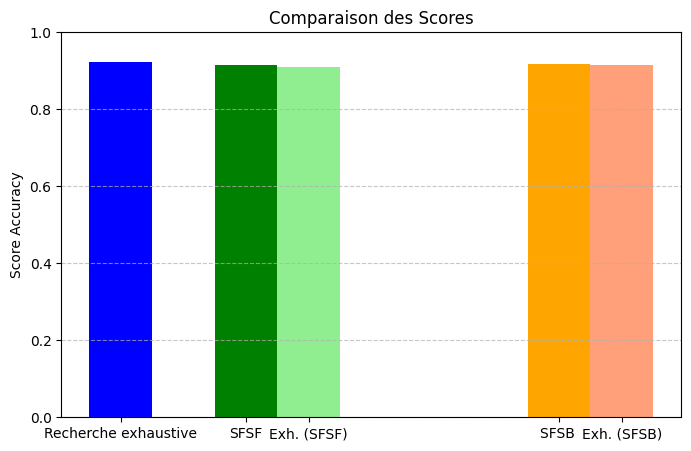

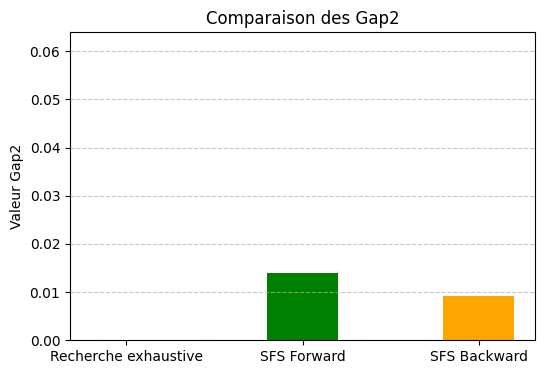

Temps d'exécution : 12.47 secondes


In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_xgb  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['gap2_accuracy'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_xgb['mean_accuracy'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['mean_accuracy'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_xgb.loc[global_results_df_xgb['mean_accuracy'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score Accuracy', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/PC/Documents/rice+cammeo+and+osmancik/Rice.data'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=XGBClassifier(eval_metric='logloss'),
    score_func=accuracy_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), f1_score, XGB

+----------------------+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   |
+======================+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive |     |     | ✔   |     |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   | ✔   |     |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   | ✔   |     |     | ✔   | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9235
Score SFS Forward : 0.9251
Score SFS Backward : 0.9277
Gap2 SFS Forward : 0.0139 | Gap2 SFS Backward : 0.0090


C:\Users\PC\AppData\Local\Temp\ipykernel_64384\1265534322.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


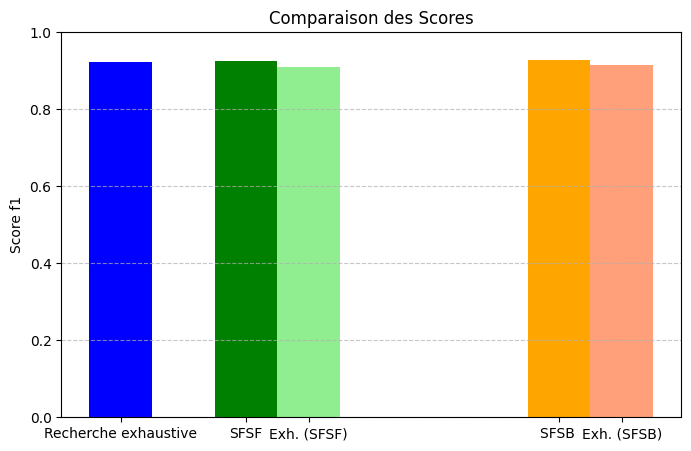

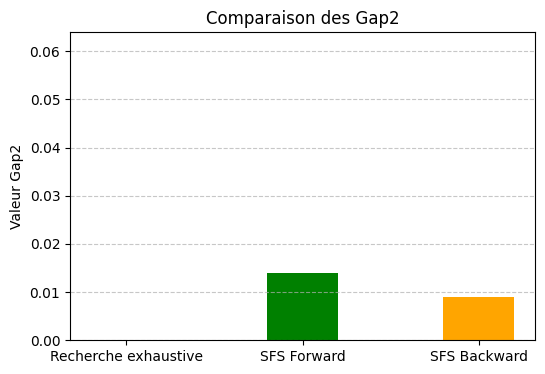

Temps d'exécution : 12.57 secondes


In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_xgb  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['gap2_f1_score'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_xgb['mean_f1_score'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['mean_f1_score'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_xgb.loc[global_results_df_xgb['mean_f1_score'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/PC/Documents/rice+cammeo+and+osmancik/Rice.data'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=XGBClassifier(eval_metric='logloss'),
    score_func=f1_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), precision_score, XGB

+----------------------+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   |
+======================+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive |     |     | ✔   |     |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   | ✔   |     |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   | ✔   |     |     | ✔   | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9240
Score SFS Forward : 0.9123
Score SFS Backward : 0.9115
Gap2 SFS Forward : 0.0142 | Gap2 SFS Backward : 0.0093


C:\Users\PC\AppData\Local\Temp\ipykernel_64384\401351814.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


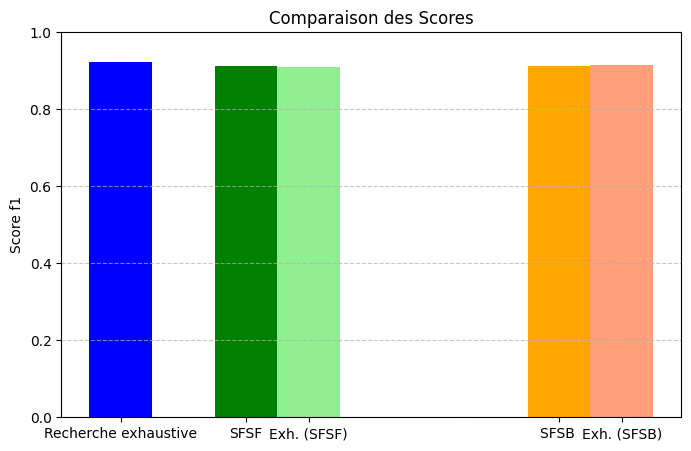

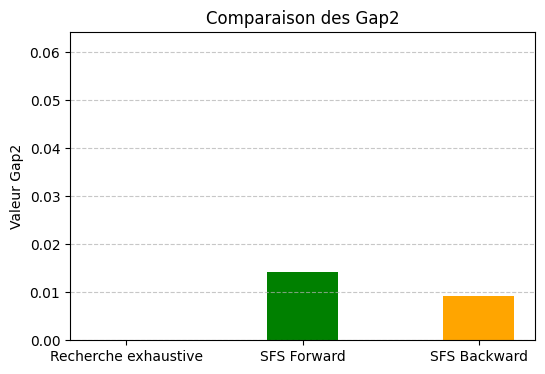

Temps d'exécution : 11.80 secondes


In [5]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_xgb  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['gap2_precision'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_xgb['mean_precision'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['mean_precision'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_xgb.loc[global_results_df_xgb['mean_precision'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/PC/Documents/rice+cammeo+and+osmancik/Rice.data'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=XGBClassifier(eval_metric='logloss'),
    score_func=precision_score,
    cv_sfs=3,
    seed=1
)


# Logit (accuracy, F1-score, précision)
## Sélection exhaustive des caractéristiques avec LogisticRegression 


In [2]:
import pandas as pd
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score
import numpy as np
import random

# Déclaration d'une variable globale pour stocker les résultats
global_results_df_logit = None

def evaluate_feature_combinations(data, classifier, cv=3, seed=3):
    global global_results_df_logit

    start_time = time.time() #debut du chronometre

    # Encode categorical attributes
    label_encoders = {}
    for column in data.columns:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

    X = data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière
    y = data.iloc[:, -1]   # Seulement la dernière colonne

    # Vérification de l'équilibre des classes
    class_counts = y.value_counts()
    min_class_size = class_counts.min()
    
    if min_class_size < cv:
        print(f"Reducing cv from {cv} to {min_class_size} due to class imbalance.")
        cv = min_class_size

    features = X.columns.tolist()
    results = []
    subsets = [()] + [subset for r in range(1, len(features) + 1) for subset in combinations(features, r)]

    # Définir les métriques à tester
    scoring_metrics = {
        "accuracy": make_scorer(accuracy_score),
        "f1_score": make_scorer(f1_score, average='weighted'),
        "precision": make_scorer(precision_score, average='weighted')
    }

    for subset in subsets:
        scores_dict = {metric: [] for metric in scoring_metrics.keys()}

        for s in range(seed):
            random.seed(s)

            if len(subset) == 0:
                X_selected = pd.DataFrame(index=X.index)
            else:
                X_selected = X[list(subset)]

            try:
                for metric, scorer in scoring_metrics.items():
                    cv_scores = cross_val_score(classifier, X_selected, y, cv=cv, scoring=scorer)
                    scores_dict[metric].extend(cv_scores)
            except ValueError:
                for metric in scoring_metrics.keys():
                    scores_dict[metric] = [0] * cv

        # Stocker les moyennes des scores pour chaque métrique
        row = {f'feature{features.index(feature) + 1}': 1 if feature in subset else 0 for feature in features}
        for metric in scoring_metrics.keys():
            row[f'mean_{metric}'] = np.mean(scores_dict[metric])

        results.append(row)

    results_df = pd.DataFrame(results)

    # Trouver les meilleurs scores pour chaque métrique
    best_scores = {metric: results_df[f'mean_{metric}'].max() for metric in scoring_metrics.keys()}

    # Ajouter les écarts par rapport aux meilleurs scores
    for metric in scoring_metrics.keys():
        results_df[f'gap1_{metric}'] = best_scores[metric] - results_df[f'mean_{metric}']
        results_df[f'gap2_{metric}'] = results_df[f'gap1_{metric}'] / best_scores[metric]

    ordered_columns = [col for col in results_df.columns if col.startswith('feature')] 
    ordered_columns += [f'mean_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap1_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap2_{metric}' for metric in scoring_metrics.keys()]

    results_df = results_df[ordered_columns]

    # Sauvegarde dans un fichier Excel
    results_df.to_excel('C:/Users/PC/Documents/rice+cammeo+and+osmancik/results_LogReg_rice.xlsx', index=False)
    global_results_df_logit = results_df

    print(f"Best mean accuracy: {best_scores['accuracy']:.4f}")
    print(f"Best mean f1-score: {best_scores['f1_score']:.4f}")
    print(f"Best mean precision: {best_scores['precision']:.4f}")

     # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")
    
    return results_df

# Chargement des données
data = pd.read_csv('C:/Users/PC/Documents/rice+cammeo+and+osmancik/Rice.data', header=None)

# Initialisation du modèle KNN
classifier = LogisticRegression(max_iter=1000)

# Exécution de la fonction avec plusieurs métriques
df_results = evaluate_feature_combinations(data, classifier, cv=3, seed=3)

# Affichage des résultats globaux
print("\n--- Résultats globaux ---")
print(global_results_df_logit.head())

Best mean accuracy: 0.9310
Best mean f1-score: 0.9309
Best mean precision: 0.9311
Temps d'exécution : 121.19 secondes

--- Résultats globaux ---
   feature1  feature2  feature3  feature4  feature5  feature6  feature7  \
0         0         0         0         0         0         0         0   
1         1         0         0         0         0         0         0   
2         0         1         0         0         0         0         0   
3         0         0         1         0         0         0         0   
4         0         0         0         1         0         0         0   

   mean_accuracy  mean_f1_score  mean_precision  gap1_accuracy  gap1_f1_score  \
0       0.000000       0.000000        0.000000       0.930971       0.930928   
1       0.879790       0.879554        0.879672       0.051181       0.051374   
2       0.911286       0.911268        0.911319       0.019685       0.019660   
3       0.926509       0.926471        0.926699       0.004462       0.004457   

## SFS (backward + forward), accuracy_score, LOGIT

+----------------------+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   |
+======================+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   |     | ✔   | ✔   | ✔   | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          |     | ✔   | ✔   |     | ✔   |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     | ✔   |     |     | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9310
Score SFS Forward : 0.9283
Score SFS Backward : 0.9318
Gap2 SFS Forward : 0.0042 | Gap2 SFS Backward : 0.0006


C:\Users\PC\AppData\Local\Temp\ipykernel_54136\3246021110.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


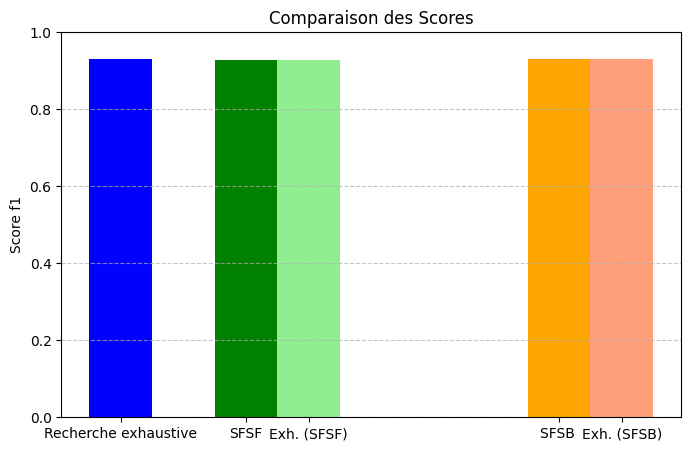

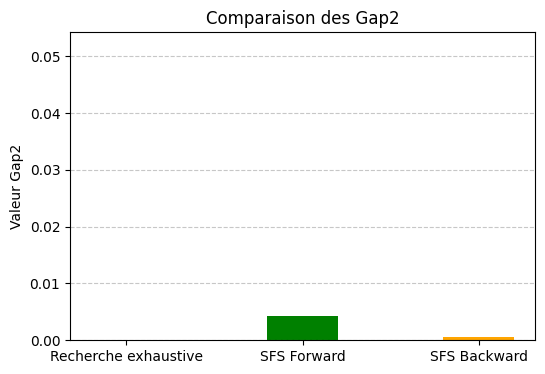

Temps d'exécution : 2.81 secondes


In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_logit  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['gap2_accuracy'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_logit['mean_accuracy'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['mean_accuracy'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_logit.loc[global_results_df_logit['mean_accuracy'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/PC/Documents/rice+cammeo+and+osmancik/Rice.data'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=LogisticRegression(max_iter=1000),
    score_func=accuracy_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), f1, LOGIT

+----------------------+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   |
+======================+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   |     | ✔   | ✔   | ✔   | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          |     | ✔   | ✔   |     | ✔   |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     | ✔   |     |     | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9309
Score SFS Forward : 0.9359
Score SFS Backward : 0.9390
Gap2 SFS Forward : 0.0042 | Gap2 SFS Backward : 0.0006


C:\Users\PC\AppData\Local\Temp\ipykernel_54136\2211466335.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


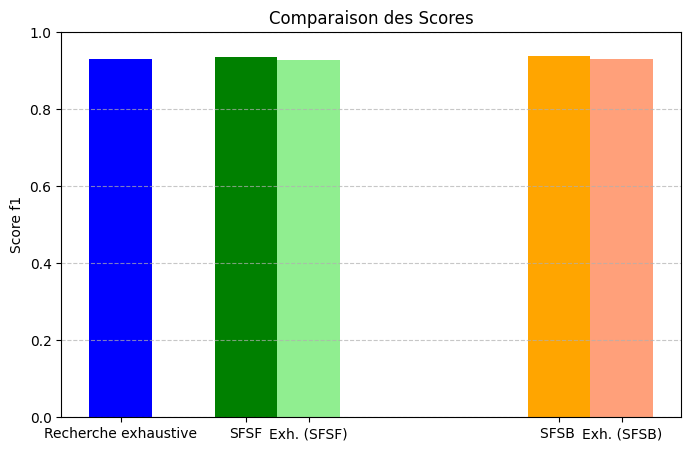

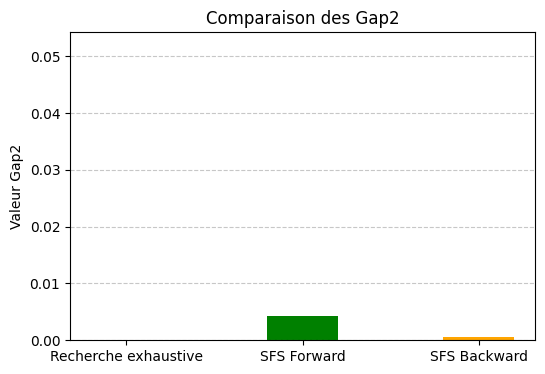

Temps d'exécution : 2.70 secondes


In [5]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_logit  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['gap2_f1_score'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_logit['mean_f1_score'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['mean_f1_score'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_logit.loc[global_results_df_logit['mean_f1_score'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/PC/Documents/rice+cammeo+and+osmancik/Rice.data'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=LogisticRegression(max_iter=1000),
    score_func=f1_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), precision_score, LOGIT

+----------------------+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   |
+======================+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   |     | ✔   | ✔   | ✔   | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          |     | ✔   | ✔   |     | ✔   |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     | ✔   |     |     | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.9311
Score SFS Forward : 0.9244
Score SFS Backward : 0.9288
Gap2 SFS Forward : 0.0042 | Gap2 SFS Backward : 0.0006


C:\Users\PC\AppData\Local\Temp\ipykernel_54136\127791049.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


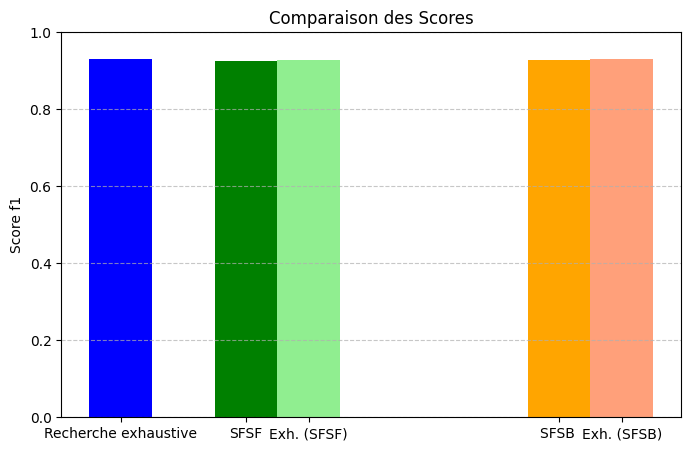

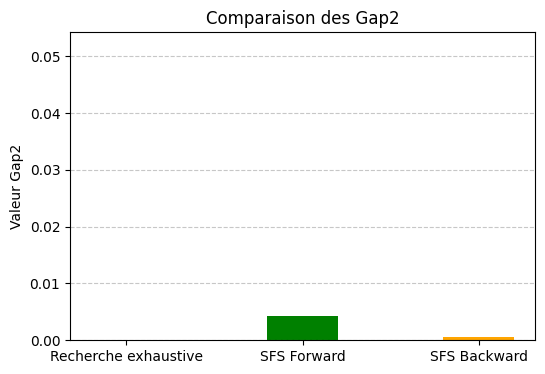

Temps d'exécution : 2.77 secondes


In [6]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_logit  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['gap2_precision'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_logit['mean_precision'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['mean_precision'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_logit.loc[global_results_df_logit['mean_precision'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/PC/Documents/rice+cammeo+and+osmancik/Rice.data'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=LogisticRegression(max_iter=1000),
    score_func=precision_score,
    cv_sfs=3,
    seed=1
)
